Found 9026 .npz files

Loading: 434996.npz

Keys in .npz file:
 - embeddings: shape (177, 768), dtype float32
 - melspectrogram: shape (177, 64), dtype float32
 - mfcc: shape (177, 32), dtype float32
 - mfcc_delta: shape (177, 32), dtype float32
 - mfcc_delta2: shape (177, 32), dtype float32
 - flatness: shape (177, 1), dtype float32
 - centroid: shape (177, 1), dtype float64
 - flux: shape (177, 1), dtype float32
 - energy: shape (177, 1), dtype float32
 - power: shape (177, 1), dtype float32
 - bandwidth: shape (177, 1), dtype float64
 - contrast: shape (177, 7), dtype float64
 - zerocrossingrate: shape (177, 1), dtype float64

Embedding shape: (177, 768)


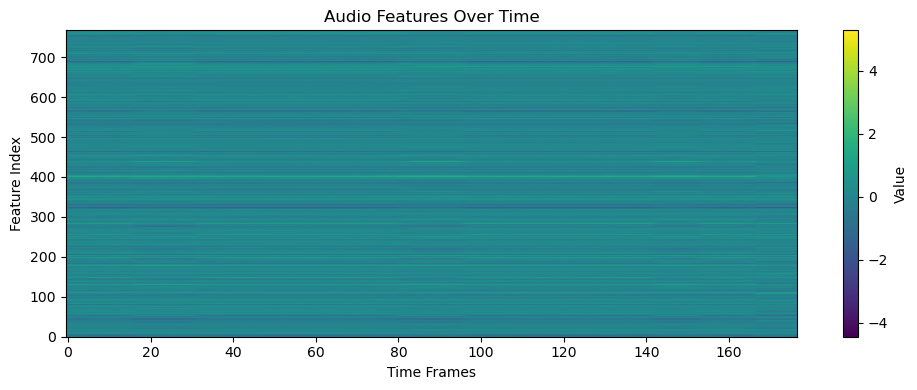

PCA explained variance (first 10 components): [0.594 0.221 0.102 0.018 0.015 0.012 0.009 0.006 0.004 0.004]


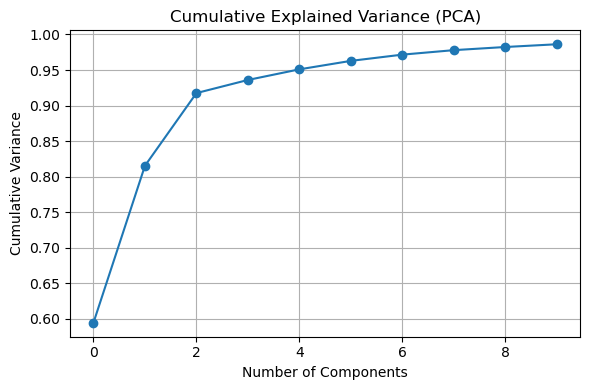

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

feature_path = "audio_features"

npz_files = [f for f in os.listdir(feature_path) if f.endswith('.npz')]
print(f"Found {len(npz_files)} .npz files")

sample_file = npz_files[0]
print(f"\nLoading: {sample_file}")

data = np.load(os.path.join(feature_path, sample_file))

print("\nKeys in .npz file:")
for key in data.files:
    print(f" - {key}: shape {data[key].shape}, dtype {data[key].dtype}")

if 'embeddings' in data:
    embeddings = data['embeddings']
else:
    for k in data.files:
        if data[k].ndim == 2:
            embeddings = data[k]
            print(f"Using fallback key: {k}")
            break
    else:
        raise ValueError("No suitable 2D feature array found.")

print(f"\nEmbedding shape: {embeddings.shape}")
plt.figure(figsize=(10, 4))
plt.imshow(embeddings.T, aspect='auto', origin='lower', cmap='viridis')
plt.title("Audio Features Over Time")
plt.xlabel("Time Frames")
plt.ylabel("Feature Index")
plt.colorbar(label="Value")
plt.tight_layout()
plt.show()

#pca
pca = PCA(n_components=10)
reduced = pca.fit_transform(embeddings)
explained = pca.explained_variance_ratio_

print(f"PCA explained variance (first 10 components): {np.round(explained, 3)}")
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(explained), marker='o')
plt.title("Cumulative Explained Variance (PCA)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd
from itertools import groupby
from operator import itemgetter

annotations_path = "annotations.csv"
features_path = "audio_features"

annotations = pd.read_csv(annotations_path)
annotated_vectors = []
silent_vectors = []

frame_duration = 0.96  # seconds per frame
grouped = annotations.groupby("filename")

for filename, group in grouped:
    file_id = os.path.splitext(filename)[0]
    npz_path = os.path.join(features_path, f"{file_id}.npz")
    
    if not os.path.exists(npz_path):
        continue

    try:
        data = np.load(npz_path)

        if "embeddings" in data:
            embeddings = data["embeddings"]
        else:
            emb_keys = [k for k in data.files if data[k].ndim == 2]
            if not emb_keys:
                continue
            embeddings = data[emb_keys[0]]

        num_frames = embeddings.shape[0]
        used_frames = np.zeros(num_frames, dtype=bool)

        for _, row in group.iterrows():
            onset = row["onset"]
            offset = row["offset"]
            start_idx = int(onset / frame_duration)
            end_idx = int(offset / frame_duration)
            start_idx = max(start_idx, 0)
            end_idx = min(end_idx, num_frames)

            if start_idx >= end_idx:
                continue

            segment = embeddings[start_idx:end_idx]
            mean_vector = segment.mean(axis=0)
            annotated_vectors.append(mean_vector)

            used_frames[start_idx:end_idx] = True

        silent_indices = np.where(~used_frames)[0]

        for k, g in groupby(enumerate(silent_indices), lambda ix: ix[0] - ix[1]):
            group_indices = list(map(itemgetter(1), g))
            if len(group_indices) >= 2:  # at least 2 frames to avg
                silent_segment = embeddings[group_indices]
                mean_vector = silent_segment.mean(axis=0)
                silent_vectors.append(mean_vector)

    except Exception as e:
        print(f"Error processing {filename}: {e}")

#array
annotated_vectors = np.array(annotated_vectors)
silent_vectors = np.array(silent_vectors)

print(f"Extracted {len(annotated_vectors)} annotated vectors")
print(f"Extracted {len(silent_vectors)} silent vectors")


Extracted 31427 annotated vectors
Extracted 11277 silent vectors


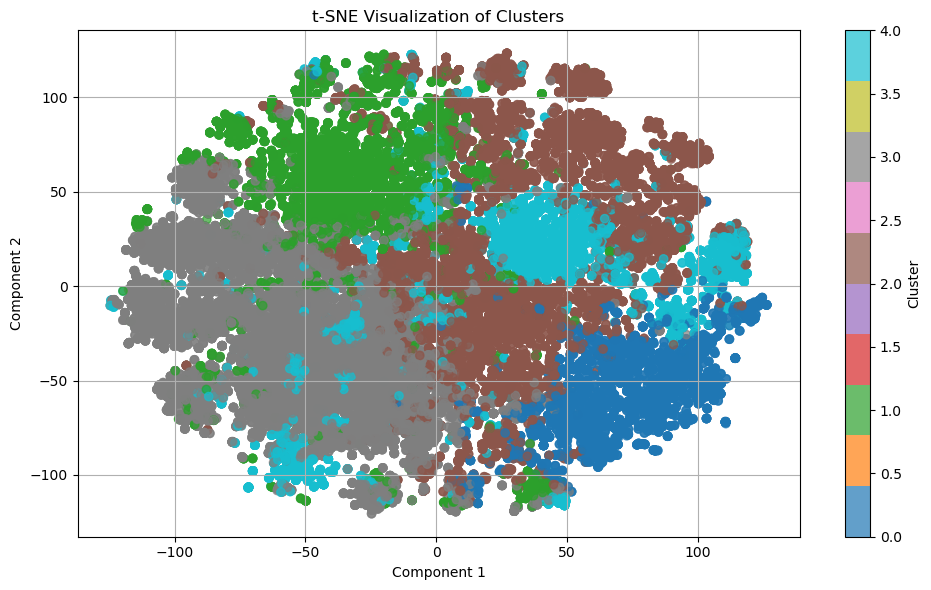


Cluster distribution for silent regions:
 - Cluster 0: 1486 silent vectors
 - Cluster 3: 3982 silent vectors
 - Cluster 1: 1283 silent vectors
 - Cluster 2: 3540 silent vectors
 - Cluster 4: 986 silent vectors

Cluster distribution for annotated regions:
 - Cluster 0: 3331 annotated vectors
 - Cluster 3: 9929 annotated vectors
 - Cluster 1: 5274 annotated vectors
 - Cluster 2: 8679 annotated vectors
 - Cluster 4: 4214 annotated vectors


In [28]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

# comb vectors
all_vectors = np.vstack([annotated_vectors, silent_vectors])
labels_true = (
    [1] * len(annotated_vectors) + 
    [0] * len(silent_vectors)
)  # 1 = annotated, 0 = silent

#kmeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(all_vectors)

#tnse
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
tsne_coords = tsne.fit_transform(all_vectors)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], 
            c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

silent_cluster_counts = Counter(np.array(cluster_labels)[np.array(labels_true) == 0])
annotated_cluster_counts = Counter(np.array(cluster_labels)[np.array(labels_true) == 1])

print("\nCluster distribution for silent regions:")
for k, v in silent_cluster_counts.items():
    print(f" - Cluster {k}: {v} silent vectors")

print("\nCluster distribution for annotated regions:")
for k, v in annotated_cluster_counts.items():
    print(f" - Cluster {k}: {v} annotated vectors")
